In [1]:
import sympy as sm
import numpy as np
import scipy as sc
import os

import networkx as nx
import matplotlib.pyplot as plt

from sympy.printing.ccode import C99CodePrinter

sm.init_printing(pretty_print=False,use_latex=True)
ccode_print = False

import inspect
import pandas as pd
#%load_ext line_profiler

# Base Matrix Expressions Classes

In [2]:
class AbstractMatrix(sm.MatrixExpr):
    
    is_commutative = False
    is_Matrix = True
    shape = (3,3)
    
    def __init__(self,sym):
        pass
    
    def doit(self):
        return self
    

In [3]:
class A(AbstractMatrix):
    
    def _latex(self,expr):
        return '{A(%s)}'%self.args[0]


class G(AbstractMatrix):
    shape = (3,4)
    

class E(AbstractMatrix):
    shape = (3,4)
    
class B(AbstractMatrix):
    shape = (3,4)
    def __init__(self,sym1,sym2):
        super().__init__(sym1)
    
    def _latex(self,expr):
        p,u = self.args
        return '{B(%s,%s)}'%(p,u.name)
    

class Triad(AbstractMatrix):
    def __init__(self,v1,v2=None):
        super().__init__(v1)

# Spatial Algebra Classes

In [4]:
class base_vector(sm.MatrixSlice):
    
    shape = (3,1)
    
    def __new__(cls,frame,sym):
        slices = {'i':(0,1),'j':(1,2),'k':(2,3)}
        return super().__new__(cls,frame.A,(0,3),slices[sym])
    
    def __init__(self,frame,sym):
        slices = {'i':(0,1),'j':(1,2),'k':(2,3)}
        self.slice = slices[sym]
        self.frame = frame
        self._sym  = sym
        self._name = '%s_%s'%(sym,frame.name)
        self._formated = '{\hat{%s}_{%s}}'%(self._sym,self.frame.name)
        self._args = (frame,sym)
    
    def express(self,frame=None):
        if frame:
            frame = frame
        else:
            frame = reference_frame._global_frame
        A = self.frame.parent.express(frame)
        return A*self
    
    def doit(self):
        return self
    
    def _latex(self,expr):
        return self._formated
    
    def _ccode(self,expr,**kwargs):
        global enclose
        if enclose:
            return '%r[:,%s:%s]'%(self.frame.name,*self.slice)
        else:
            return '%s[:,%s:%s]'%(self.frame.name,*self.slice)
    
    def _sympystr (self,expr):
        return '%s[:,%s]'%(self.frame.name,self.slice)
    
    '''def _pretty(self,expr):
        return self._formated'''
    
    @property
    def name(self):
        return '{\hat{%s}_{%s}}'%(self._sym,self.frame.name)
    
    
    '''def doit(self):
        return self.frame[:,self.slices]'''
    
    @property
    def func(self):
        return base_vector

In [5]:
class dcm(sm.MatrixSymbol):
    shape = (3,3)
    
    is_commutative = False
    
    def __new__(cls,name, format_as=None):
        
        if format_as:
            name = format_as
        
        return super(dcm,cls).__new__(cls,name,3,3)
    
    def __init__(self,name, frame=None, format_as=None):
        
        self._raw_name = name
        self._formated_name = super().name
        
        self._args=(self._raw_name,self._formated_name)
    
    def doit(self):
        return self
    
    @property
    def name(self):
        if ccode_print:
            return self.args[0]
        else:
            return self.args[1]
    @property
    def func(self):
        return dcm
        

In [6]:
class zero_matrix(sm.MatrixSymbol):
    
    def __new__(cls,m,n):
        sym = '{Z_{%sx%s}}'%(m,n)
        return super().__new__(cls,sym,m,n)
    def __init__(self,m,n):
        self.sym = super().name
        self._args = (m,n)
    
    def _latex(self,expr):
        return self.sym
    def _ccode(self,expr,**kwargs):
        return 'np.zeros((%s,%s),dtype=np.float64)'%(self.shape)
    def _sympystr(self,expr):
        return 'zero_matrix(%s,%s)'%self.shape
    
    def doit(self):
        return self
    @property
    def func(self):
        return zero_matrix
    @property
    def shape(self):
        return self._args

In [7]:
class reference_frame(object):
    
    reference_tree = nx.DiGraph()
    
    _global_set   = False
    _global_frame = None
    _is_global    = False
    
    @classmethod
    def _set_global_frame(cls,name):
        cls._global_set = True
        cls._global_frame  = reference_frame(name)
        cls._global_frame._is_global = True
        cls.reference_tree.add_node(cls._global_frame.name)
    @classmethod
    def show_tree(cls):
        nx.draw(cls.reference_tree,with_labels=True)
        plt.show()
    
    
    def __new__(cls, name, parent=None,format_as=None):
        if not cls._global_set:
            cls._set_global_frame('grf')
        return super(reference_frame,cls).__new__(cls)
    
    
    def __init__(self, name, parent=None,format_as=None):
        #print('Inside reference_frame()')
        self._raw_name = name
        self._formated_name = (format_as if format_as else name)
        self._key = name
    
        self.parent = (parent if parent else reference_frame._global_frame)
        
        self._A = dcm(self._raw_name,self._formated_name)
        
        self.i = base_vector(self,'i')
        self.j = base_vector(self,'j')
        self.k = base_vector(self,'k')
        
        self.update_tree()
            
    def update_tree(self):
        if self.parent :
            reference_frame.reference_tree.add_edge(self.parent._key, self._key, mat=self.A.T)
            reference_frame.reference_tree.add_edge(self._key, self.parent._key, mat=self.A)
    
    @property
    def A(self):
        return self._A
    @A.setter
    def A(self,value):
        self._A = value
        self.i = base_vector(self,'i')
        self.j = base_vector(self,'j')
        self.k = base_vector(self,'k')
        self.update_tree()
    
    @property
    def name(self):
        global ccode_print
        if ccode_print:
            return self._raw_name
        else:
            return self._formated_name
    
    
    def express(self,other):
        
        child_name  = self._key
        parent_name = other._key
        graph = reference_frame.reference_tree
        
        path_nodes  = nx.algorithms.shortest_path(graph, child_name, parent_name)
        path_matrices = []
        for i in range(len(path_nodes)-1):
            path_matrices.append(graph.edges[path_nodes[-i-2],path_nodes[-i-1]]['mat'])
        
        mat   = sm.MatMul(*path_matrices)
        return mat
    
    def orient_along(self,v1,v2=None):
        if v2 is None:
            self.A = Triad(v1)
        else:
            self.A = Triad(v1,v2)
    

In [8]:
class vector(sm.MatrixSymbol):
    shape = (3,1)
    
    is_commutative = False
    
    def __new__(cls,name, frame=None, format_as=None):
        
        if format_as:
            name = format_as
        
        return super(vector,cls).__new__(cls,name,3,1)
    
    def __init__(self,name, frame=None, format_as=None):
        
        self._raw_name = name
        self._formated_name = super().name
        
        if frame:
            self.frame = frame
        else:
            self.frame = reference_frame._global_frame
        
        self._args = (name,self.frame,self._formated_name)
    
    def express(self,frame=None):
        if frame:
            frame = frame
        else:
            frame = reference_frame._global_frame
        A = self.frame.express(frame)
        return A*self
    
    
    def doit(self):
        return self
    
    @property
    def name(self):
        if ccode_print:
            return self.args[0]
        else:
            return self.args[2]
    

    

In [9]:
class quatrenion(sm.MatrixSymbol):
    shape = (4,1)
    
    is_commutative = False
    
    def __new__(cls, name, format_as=None):
        if format_as:
            name = format_as
        return super(quatrenion,cls).__new__(cls,name,*cls.shape)
    
    def __init__(self,name, format_as=None):
        self._raw_name = name
        self._formated_name = super().name
        
        self._args = (name,self._formated_name)
    
    def doit(self):
        return self
    
    @property
    def func(self):
        return self.__class__
        
        
    @property
    def name(self):
        if ccode_print:
            return self.args[0]
        else:
            return self.args[1]
    

# Common MBS Data Class

In [10]:
class abstract_mbs(object):
    
    def configuration_constants(self):
        if isinstance(self,body):
            return []
        elif isinstance(self,algebraic_constraints):
            loc  = vector('pt_%s'%self.name)
            axis = vector('ax_%s'%self.name)

            ui_bar_eq = sm.Eq(self.ui_bar, loc.express(self.body_i) - self.Ri.express(self.body_i))
            uj_bar_eq = sm.Eq(self.uj_bar, loc.express(self.body_j) - self.Rj.express(self.body_j))

            marker = reference_frame('M_%s'%self.name,format_as=r'{{M}_{%s}}'%self.name)
            symbol = marker._A
            marker.orient_along(axis)
            marker_eq = sm.Eq(symbol,marker.A)

            mi_bar      = marker.express(self.body_i)
            mi_bar_eq   = sm.Eq(self.mi_bar.A, marker.express(self.body_i))

            mj_bar      = marker.express(self.body_j)
            mj_bar_eq   = sm.Eq(self.mj_bar.A, marker.express(self.body_j))

            assignments = [ui_bar_eq,uj_bar_eq,mi_bar_eq,mj_bar_eq]
            return assignments
    
    def numerical_arguments(self):
        if isinstance(self,body):
            R = sm.Eq(self.R,sm.MutableDenseMatrix([0,0,0]))
            P = sm.Eq(self.P,sm.MutableDenseMatrix([1,0,0,0]))
            Rd = sm.Eq(self.Rd,sm.MutableDenseMatrix([0,0,0]))
            Pd = sm.Eq(self.Pd,sm.MutableDenseMatrix([1,0,0,0]))
            return [R,P,Rd,Pd]
        
        elif isinstance(self,algebraic_constraints):
            loc  = vector('pt_%s'%self.name)
            axis = vector('ax_%s'%self.name)
            
            loc  = sm.Eq(loc,sm.MutableDenseMatrix([0,0,0]))
            axis = sm.Eq(axis,sm.MutableDenseMatrix([0,0,1]))
            return [loc,axis]

# Bodies Classes

In [140]:
class body(reference_frame,abstract_mbs):
    
    n   = 7
    nc  = 1
    nve = 1
    
    def __init__(self,name):
        super().__init__(name)
        #print('Inside body()')
        self._key = name
        
        self.R  = vector('R_%s'%name, format_as='{R_{%s}}'%name)
        self.Rd = vector('Rd_%s'%name, format_as='{Rd_{%s}}'%name)
        
        self.P  = quatrenion('P_%s'%name, format_as='{P_{%s}}'%name)
        self.Pd = quatrenion('Pd_%s'%name, format_as='{Pd_{%s}}'%name)
        
        #print('Generating DCM')
        self.A = A(self.P)
                
        #print('Generating Normalized Equations')
        self.normalized_pos_equation = sm.sqrt(self.P.T*self.P)-sm.Identity(1)
        self.normalized_vel_equation = zero_matrix(1,1)
        self.normalized_acc_equation = 2*sm.sqrt(self.Pd.T*self.Pd)
        self.normalized_jacobian = [zero_matrix(1,3), 2*self.P.T]
        
        #print('Exiting Body \n')
    
    @property
    def name(self):
        return self._key


In [141]:
class ground(body):
    
    n   = 7
    nc  = 7
    nve = 2
    
    def __new__(cls):
        name = 'ground'
        return super().__new__(cls,name)
    def __init__(self):
        super().__init__('ground')
        self._key = 'ground'
        self.P_ground = quatrenion('Pg_%s'%self.name,format_as='{Pg_{%s}}'%self.name)
        
        self.normalized_pos_equation = sm.BlockMatrix([[self.R], [self.P-self.P_ground]])
        self.normalized_vel_equation = sm.BlockMatrix([[zero_matrix(3,1)],[zero_matrix(4,1)]])
        self.normalized_acc_equation = sm.BlockMatrix([[zero_matrix(3,1)],[zero_matrix(4,1)]])
        self.normalized_jacobian = sm.BlockMatrix([[sm.Identity(3),zero_matrix(3,4)],
                                                   [zero_matrix(4,3),sm.Identity(4)]])
    

# Algebraic Constraints

In [13]:
I = sm.Identity(3)

class algebraic_constraints(object):
    
    def __init__(self,name,body_i=None,body_j=None):
        self.name = name
        
        self._pos_level_equations = []
        self._vel_level_equations = []
        self._acc_level_equations = []
        self._jacobian_i = []
        self._jacobian_j = []
        
        try:
            self.body_i = body_i
            self.body_j = body_j
        except AttributeError:
            pass
    
    def construct(self):
        pass
    
    @property
    def body_i(self):
        return self._body_i
    @body_i.setter
    def body_i(self,body_i):
        self._body_i = body_i
        self.Ri  = body_i.R
        self.Rdi = body_i.Rd
        self.Pi  = body_i.P
        self.Pdi = body_i.Pd
        self.Ai  = body_i.A
        self.ui_bar = vector('ubar_%s_%s'%(body_i.name,self.name),frame=body_i,
                             format_as=r'{\bar{u}^{%s}_{%s}}'%(body_i.name,self.name))
        self.mi_bar = reference_frame('Mbar_%s_%s'%(body_i.name,self.name),parent=body_i,
                                      format_as=r'{\bar{M}^{%s}_{%s}}'%(body_i.name,self.name))
        self.Bui = B(self.Pi,self.ui_bar)
        self.ui = self.ui_bar.express(reference_frame._global_frame)
        try:
            self.construct()
        except AttributeError:
            pass
    
    @property
    def body_j(self):
        return self._body_j
    @body_j.setter
    def body_j(self,body_j):
        self._body_j = body_j
        self.Rj  = body_j.R
        self.Rdj = body_j.Rd
        self.Pj  = body_j.P
        self.Pdj = body_j.Pd
        self.Aj  = body_j.A
        self.uj_bar = vector('ubar_%s_%s'%(self.body_j.name,self.name),frame=body_j,
                             format_as=r'{\bar{u}^{%s}_{%s}}'%(self.body_j.name,self.name))
        self.mj_bar = reference_frame('Mbar_%s_%s'%(self.body_j.name,self.name),parent=body_j,
                                      format_as=r'{\bar{M}^{%s}_{%s}}'%(self.body_j.name,self.name))
        self.Buj = B(self.Pj,self.uj_bar)
        self.uj = self.uj_bar.express(reference_frame._global_frame)
        try:
            self.construct()
        except AttributeError:
            pass
    
    @property
    def dij(self):
        return self.Ri + self.ui - self.Rj - self.uj
    @property
    def pos_level_equations(self):
        return sm.BlockMatrix(self._pos_level_equations)
    @property
    def vel_level_equations(self):
        return sm.BlockMatrix(self._vel_level_equations)
    @property
    def acc_level_equations(self):
        return sm.BlockMatrix(self._acc_level_equations)
    @property
    def jacobian_i(self):
        return sm.BlockMatrix(self._jacobian_i)
    @property
    def jacobian_j(self):
        return sm.BlockMatrix(self._jacobian_j)
    

In [168]:
class spehrical_constraint(object):
    
    nc  = 3
    
    def __init__(self):
        pass
    
    def construct(self,obj):
        pos_level_equation = obj.dij
        vel_level_equation = zero_matrix(3,1)
        acc_level_equation = B(obj.Pdi,obj.ui_bar)*obj.Pdi\
                            -B(obj.Pdj,obj.uj_bar)*obj.Pdj
            
        jacobian = ([ I,  obj.Bui] , [-I, -obj.Buj])
        
        obj._pos_level_equations.append(pos_level_equation)
        obj._vel_level_equations.append(vel_level_equation)
        obj._acc_level_equations.append(acc_level_equation)
        
        obj._jacobian_i.append(jacobian[0])
        obj._jacobian_j.append(jacobian[1])
    
    
class dot_product_1(object):
    
    nc  = 1
    
    def __init__(self,v1='i',v2='j'):
        self.v1 = v1
        self.v2 = v2
    
    def construct(self,obj):
        v1 = self.v1
        v2 = self.v2
        
        v1_bar = getattr(obj.mi_bar,v1)
        v1     = v1_bar.express()
        v2_bar = getattr(obj.mj_bar,v2)
        v2     = v2_bar.express()
        
        Pdi = obj.Pdi
        Pdj = obj.Pdj
        Z = zero_matrix(1,3)
        
        pos_level_equation = v1.T*v2
        vel_level_equation = zero_matrix(1,1)
        acc_level_equation =   v1.T*B(Pdj,v2_bar)*Pdj \
                             + v2.T*B(Pdi,v1_bar)*Pdi \
                             + 2*(B(obj.Pi,v1_bar)*Pdi).T*(B(obj.Pj,v2_bar)*Pdj)
        
        jacobian = ([Z, v2.T*B(obj.Pi,v1_bar)], [Z, v1.T*B(obj.Pj,v2_bar)])
        
        obj._pos_level_equations.append(pos_level_equation)
        obj._vel_level_equations.append(vel_level_equation)
        obj._acc_level_equations.append(acc_level_equation)
        
        obj._jacobian_i.append(jacobian[0])
        obj._jacobian_j.append(jacobian[1])
    

class dot_product_2(object):
    
    nc  = 1
    
    def __init__(self,v='i'):
        self.v = v
    
    def construct(self,obj):
        v = self.v
        
        v_bar = getattr(obj.mi_bar,v)
        v = v_bar.express()
        dij = obj.dij
        Rdi = obj.Rdi
        Rdj = obj.Rdj
        Pdi = obj.Pdi
        Pdj = obj.Pdj
        dijd = Rdi + obj.Bui*Pdi - Rdj + obj.Buj*Pdj
        
        pos_level_equation = v.T*dij
        vel_level_equation = zero_matrix(1,1)
        acc_level_equation =   v.T*(B(Pdj,obj.uj_bar)*Pdj - B(Pdi,obj.ui_bar)*Pdi) \
                             + dij.T*B(Pdi,v_bar)*Pdi \
                             + 2*(B(obj.Pi,v_bar)*Pdi).T*dijd
        jacobian = ([-v.T, dij.T*B(obj.Pi,v_bar) - v.T*obj.Bui], [ v.T, v.T*obj.Buj])
        
        obj._pos_level_equations.append(pos_level_equation)
        obj._vel_level_equations.append(vel_level_equation)
        obj._acc_level_equations.append(acc_level_equation)
        
        obj._jacobian_i.append(jacobian[0])
        obj._jacobian_j.append(jacobian[1])


In [169]:
class joint_constructor(type):
    
    def __new__(mcls, name, bases, attrs):
        
        vector_equations = attrs['vector_equations']
        nve = len(vector_equations)
        nc  = sum([e.nc for e in vector_equations])
        
        def construct(self):
            for e in vector_equations:
                e.construct(self)
            
        attrs['construct'] = construct
        attrs['nve'] = nve
        attrs['nc']  = nc
        attrs['n']  = 0
        
        bases = list(bases) + [abstract_mbs,]
        
        return super(joint_constructor, mcls).__new__(mcls, name, tuple(bases), attrs)
    

In [170]:
class fixed(algebraic_constraints,metaclass=joint_constructor):
    vector_equations = [spehrical_constraint(),
                        dot_product_1('i','k'),
                        dot_product_1('j','k'),
                        dot_product_1('i','j')]


class spherical(algebraic_constraints,metaclass=joint_constructor):
    vector_equations = [spehrical_constraint()]

class revolute(algebraic_constraints,metaclass=joint_constructor):
    vector_equations = [spehrical_constraint(),
                        dot_product_1('i','k'),
                        dot_product_1('j','k')]

class cylinderical(algebraic_constraints,metaclass=joint_constructor):
    vector_equations = [dot_product_1('i','k'),
                        dot_product_1('j','k'),
                        dot_product_2('i'),
                        dot_product_2('j')]
    
class translational(algebraic_constraints,metaclass=joint_constructor):
    vector_equations = [dot_product_1('i','k'),
                        dot_product_1('j','k'),
                        dot_product_2('i'),
                        dot_product_2('j'),
                        dot_product_1('i','j')]

class universal(algebraic_constraints,metaclass=joint_constructor):
    vector_equations = [spehrical_constraint(),
                        dot_product_1('i','i')]
    
    def configuration_constants(self):
        loc  = vector('pt_%s'%self.name)
        axis_1 = vector('ax1_%s'%self.name)
        axis_2 = vector('ax2_%s'%self.name)

        ui_bar_eq = sm.Eq(self.ui_bar, loc.express(self.body_i) - self.Ri.express(self.body_i))
        uj_bar_eq = sm.Eq(self.uj_bar, loc.express(self.body_j) - self.Rj.express(self.body_j))

        marker_1 = reference_frame('M1_%s'%self.name,format_as=r'{{M1}_{%s}}'%self.name)
        symbol_1 = marker_1.A
        marker_1.orient_along(axis_1)
        marker_1_eq = sm.Eq(symbol_1,marker_1.A)
        
        marker_2 = reference_frame('M2_%s'%self.name,format_as=r'{{M2}_{%s}}'%self.name)
        symbol_2 = marker_2.A
        marker_2.orient_along(axis_2,marker_1.A[:,1])
        marker_2_eq = sm.Eq(symbol_2,marker_2.A)

        mi_bar      = marker_1.express(self.body_i)
        mi_bar_eq   = sm.Eq(self.mi_bar.A, marker_1.express(self.body_i))

        mj_bar      = marker_2.express(self.body_j)
        mj_bar_eq   = sm.Eq(self.mj_bar.A, marker_2.express(self.body_j))

        assignments = [ui_bar_eq,uj_bar_eq,mi_bar_eq,mj_bar_eq]
        return assignments
    
    def numerical_arguments(self):
        loc  = vector('pt_%s'%self.name)
        axis_1 = vector('ax1_%s'%self.name)
        axis_2 = vector('ax2_%s'%self.name)

        loc  = sm.Eq(loc,sm.MutableDenseMatrix([0,0,0]))
        axis_1 = sm.Eq(axis_1,sm.MutableDenseMatrix([0,0,1]))
        axis_2 = sm.Eq(axis_2,sm.MutableDenseMatrix([0,0,1]))
        return [loc,axis_1,axis_2]


In [313]:
class joint_actuator(algebraic_constraints):
    
    def __init__(self,name,joint):
        body_i = joint.body_i
        body_j = joint.body_j
        
        t = self.t = sm.symbols('t')
        
        self.F = sm.Function('F')
        self._pos_function = sm.sin(self.F(t))
        self._vel_function = sm.diff(self._pos_function,t)
        self._acc_function = sm.diff(self._pos_function,t,t)
        
        super().__init__(joint.name,body_i,body_j)
        self.name = name
    
    @property
    def pos_level_equations(self):
        return sm.BlockMatrix([self._pos_level_equations[0] - sm.Identity(1)*self._pos_function])
    @property
    def vel_level_equations(self):
        return sm.BlockMatrix([self._vel_level_equations[0] - sm.Identity(1)*self._vel_function])
    @property
    def acc_level_equations(self):
        return sm.BlockMatrix([self._acc_level_equations[0] - sm.Identity(1)*self._acc_function])
    
    def numerical_arguments(self):
        function  = sm.Eq(self.F,sm.Function('FunctionNameHere'))
        return [function]
    def configuration_constants(self):
        return []
    
class rotational_actuator(joint_actuator,metaclass=joint_constructor):
    vector_equations = [dot_product_1('i','j')]
    

In [172]:
class absolute_locator(object):
    
    coordinates_map = {'x':0,'y':1,'z':2}
    n   = 0
    nc  = 1
    nve = 1
    
    def __init__(self,name,body,coordinate):
        self.name = name
        self.body = body
        self.coordinate = coordinate
        
        t = self.t = sm.symbols('t')
        self.F = sm.Function('F')
        self._pos_function = self.F(t)
        self._vel_function = sm.diff(self._pos_function,t)
        self._acc_function = sm.diff(self._pos_function,t,t)
        
        i = self.coordinates_map[self.coordinate]
        self._pos_level_equations = [self.body.R[i,0] - self._pos_function]
        self._vel_level_equations = [self._vel_function]
        self._acc_level_equations = [self._acc_function]
    
    @property
    def pos_level_equations(self):
        return sm.BlockMatrix([self._pos_level_equations])
    @property
    def vel_level_equations(self):
        return sm.BlockMatrix([self._vel_level_equations])
    @property
    def acc_level_equations(self):
        return sm.BlockMatrix([self._acc_level_equations])


In [204]:
a = body('a')
b = body('b')

In [205]:
j = revolute('f')

In [206]:
j.body_i = a
j.body_j = b

In [208]:
ccode_print = False
j.jacobian_i, j.jacobian_j

(Matrix([
[               I,                                                      B({P_{a}}, {\bar{u}^{a}_{f}})],
[zero_matrix(1,3), {\bar{M}^{b}_{f}}[:,(2, 3)].T*A({P_{b}}).T*B({P_{a}}, {\bar{M}^{a}_{f}}[:,(0, 1)])],
[zero_matrix(1,3), {\bar{M}^{b}_{f}}[:,(2, 3)].T*A({P_{b}}).T*B({P_{a}}, {\bar{M}^{a}_{f}}[:,(1, 2)])]]), Matrix([
[              -I,                                                     -B({P_{b}}, {\bar{u}^{b}_{f}})],
[zero_matrix(1,3), {\bar{M}^{a}_{f}}[:,(0, 1)].T*A({P_{a}}).T*B({P_{b}}, {\bar{M}^{b}_{f}}[:,(2, 3)])],
[zero_matrix(1,3), {\bar{M}^{a}_{f}}[:,(1, 2)].T*A({P_{a}}).T*B({P_{b}}, {\bar{M}^{b}_{f}}[:,(2, 3)])]]))

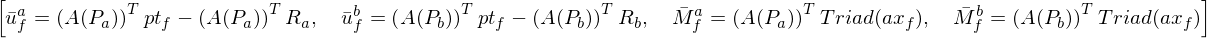

In [157]:
j.configuration_constants()

In [142]:
j_act = rotational_actuator('j_act',j)

In [143]:
j_act.numerical_arguments()

In [125]:
j_act.nve

In [24]:
j_act.pos_level_equations

Matrix([[(-cos(F(t)))*I + {\bar{M}^{a}_{f}}[:,(0, 1)].T*A({P_{a}}).T*A({P_{b}})*{\bar{M}^{b}_{f}}[:,(0, 1)]]])

In [25]:
j_act.vel_level_equations

Matrix([[(sin(F(t))*Derivative(F(t), t))*I + zero_matrix(1,1)]])

In [26]:
j_act.acc_level_equations

Matrix([[(sin(F(t))*Derivative(F(t), (t, 2)) + cos(F(t))*Derivative(F(t), t)**2)*I + {\bar{M}^{b}_{f}}[:,(0, 1)].T*A({P_{b}}).T*B({Pd_{a}}, {\bar{M}^{a}_{f}}[:,(0, 1)])*{Pd_{a}} + {\bar{M}^{a}_{f}}[:,(0, 1)].T*A({P_{a}}).T*B({Pd_{b}}, {\bar{M}^{b}_{f}}[:,(0, 1)])*{Pd_{b}} + 2*{Pd_{a}}.T*B({P_{a}}, {\bar{M}^{a}_{f}}[:,(0, 1)]).T*B({P_{b}}, {\bar{M}^{b}_{f}}[:,(0, 1)])*{Pd_{b}}]])

In [29]:
j_loc = absolute_locator('abs',a,'x')

In [31]:
j_loc.vel_level_equations

Matrix([[Derivative(F(t), t)]])

In [21]:
#%%timeit

g = ground()
l1 = body('l1')
l2 = body('l2')
l3 = body('l3')

a = revolute('a',g,l1)
b = spherical('b',l1,l2)
c = cylinderical('c',l2,l3)
d = revolute('d',l3,g)

#act = rotational_actuator('rot',a)

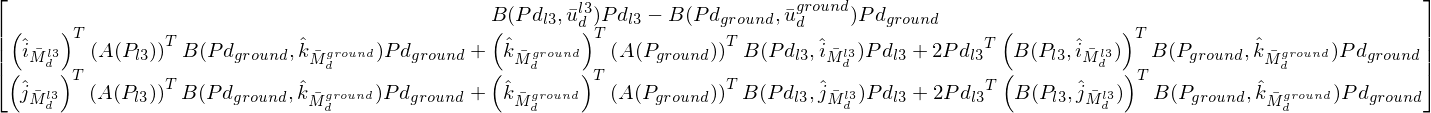

In [22]:
d.acc_level_equations

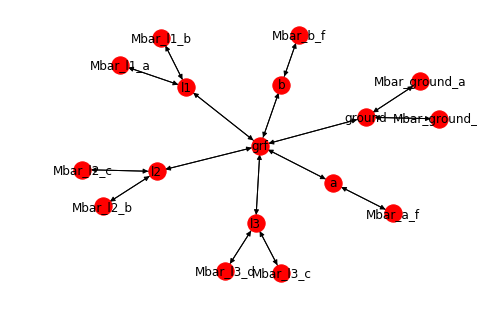

In [23]:
reference_frame.show_tree()

In [47]:
#%timeit da = revolute('da',g,l1)
#44.7 ms ± 3.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
#29.1 ms ± 4.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
#26 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each) -- 5Dec2018

26 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Topology Creators

In [173]:
class topology(object):
    
    def __init__(self,name,*args,**kwargs):
        self.data_graph = nx.MultiGraph(name=name)
        self._selected_variant = nx.MultiGraph(name=name,n=0,nc=0,nve=0)
        self.name = name
        self._edges_map = {}
    
    @property
    def selected_variant(self):
        return self._selected_variant
    
    @property
    def n(self):
        variant = self.selected_variant
        n = sum([node[-1] for node in variant.nodes(data='n')])
        return n
    @property
    def nc(self):
        variant = self.selected_variant
        nc_nodes = sum([node[-1] for node in variant.nodes(data='nc')])
        nc_edges = sum([edge[-1] for edge in variant.edges(data='nc')])
        return nc_nodes + nc_edges
    @property
    def nve(self):
        variant = self.selected_variant
        nve_nodes = sum([node[-1] for node in variant.nodes(data='nve')])
        nve_edges = sum([edge[-1] for edge in variant.edges(data='nve')])
        return nve_nodes + nve_edges
    @property
    def constants(self):
        nodes_constants = sum([node[-1] for node in self.data_graph.nodes(data='constants')],[])
        edges_constants = sum([edge[-1] for edge in self.data_graph.edges(data='constants')],[])
        return nodes_constants + edges_constants
    
    
    def _attr_gen(self,obj):
        variant_graph_dict ={'n':obj.n,'nc':obj.nc,'nve':obj.nve,'class':obj}
        return variant_graph_dict
    
    def add_body(self,name):
        if name not in self.data_graph.nodes():
            variant_graph_dict = self._attr_gen(body)
            self.data_graph.add_node(name,**variant_graph_dict)
            self.selected_variant.add_node(name,**variant_graph_dict)
        
    
    def add_joint(self,typ,name,body_i,body_j):
        edge  = (body_i,body_j,name)
        if edge not in self.data_graph.edges:
            variant_graph_dict = self._attr_gen(typ)
            self.data_graph.add_edge(*edge,**variant_graph_dict)
            self.selected_variant.add_edge(*edge,**variant_graph_dict)
            self._edges_map[name] = edge
            
    def add_joint_actuator(self,typ,name,joint_name):
        joint_edge = self._edges_map[joint_name]
        act_edge = (*joint_edge[:2],name)
        if act_edge not in self.data_graph.edges:
            variant_graph_dict = self._attr_gen(typ)
            self.data_graph.add_edge(*act_edge,**variant_graph_dict,joint_name=joint_name)
            self.selected_variant.add_edge(*act_edge,**variant_graph_dict,joint_name=joint_name)
            self._edges_map[name] = act_edge
    
    '''def add_actuator(self,typ,name,joint_name):
        graph = self.data_graph
        joint_edge = self._edges_map[joint_name]
        act_edge = (*joint_edge[:2],name)
        if act_edge not in graph.edges(data='key'):
            joint = graph.edges[joint_edge]['obj']
            act = typ(name,joint)
            data_graph_dict, variant_graph_dict = self._attr_gen(act)
            graph.add_edge(*act_edge,**data_graph_dict)
            self.selected_variant.add_edge(*act_edge,**variant_graph_dict)
            self._edges_map[name] = act_edge'''
    
    def remove_body(self,name):
        self.data_graph.remove_node(name)
        self.selected_variant.remove_node(name)
    
    def remove_joint(self,name):
        edge = self._edges_map[name]
        self.data_graph.remove_edge(*edge)
    
    def draw_topology(self):
        plt.figure(figsize=(6,6))
        nx.draw_spring(self.selected_variant,with_labels=True)
        plt.show()
    
        

In [174]:
class template_based_topology(topology):
    
    def __init__(self,name,*args,**kwargs):
        super().__init__(name,*args,**kwargs)
        
        self.variants = {}
        self._selected_variant =nx.MultiGraph(name='base_variant_%s'%name)
        self.variants['base_variant_%s'%name] = self._selected_variant
    
    @property
    def selected_variant(self):
        return self._selected_variant
    
    @selected_variant.setter
    def selected_variant(self,name):
        self._selected_variant = self.variants[name]
    
    @property
    def virtual_bodies(self):
        condition = lambda n: n.startswith('vbs_') or n.startswith('vbr_')
        virtuals  = filter(condition,self.selected_variant.nodes)
        return set(virtuals)
    
    def creat_variant(self,name,initial_copy=None,override=False):
        name = 'variant_%s'%name
        if name in self.variants.keys() and not override:
            raise ValueError('Variant "%s" already exists, Please enter another name'%name)
        else:
            if initial_copy is not None:
                variant = initial_copy.copy()
                variant.name = name
            else:
                variant = nx.MultiGraph(name='variant_%s'%name)
            self.variants[name] = variant
            self.selected_variant = name   
    
    def add_body(self,name,mirrored=False):
        variant = self.selected_variant
        if mirrored:
            node1 = 'rbr_%s'%name
            node2 = 'rbl_%s'%name
            super().add_body(node1)
            super().add_body(node2)
            variant.nodes[node1]['mirr'] = self.data_graph.nodes[node1]['mirr'] = node2
            variant.nodes[node2]['mirr'] = self.data_graph.nodes[node2]['mirr'] = node1 
        else:
            node1 = node2 = 'rbs_%s'%name
            super().add_body(node1)
            variant.nodes[node1]['mirr'] = self.data_graph.nodes[node1]['mirr'] = node2
    
    def add_virtual_body(self,name,mirrored=False):
        variant = self.selected_variant
        if mirrored:
            node1 = 'vbr_%s'%name
            node2 = 'vbl_%s'%name
            super().add_body(node1)
            super().add_body(node2)
            variant.nodes[node1]['mirr'] = self.data_graph.nodes[node1]['mirr'] = node2
            variant.nodes[node2]['mirr'] = self.data_graph.nodes[node2]['mirr'] = node1 
        else:
            node1 = node2 = 'vbs_%s'%name
            super().add_body(node1)
            variant.nodes[node1]['mirr'] = self.data_graph.nodes[node1]['mirr'] = node2
    
    def add_joint(self,typ,name,body_i,body_j,mirrored=False):
        variant = self.selected_variant
        if mirrored:
            body_i_mirr = variant.nodes[body_i]['mirr']
            body_j_mirr = variant.nodes[body_j]['mirr']
            key1 = 'jcr_%s'%name
            key2 = 'jcl_%s'%name
            #variant.edges[(body_i,body_j,key1)]['mirr'] = self.data_graph.edges[(body_i,body_j,key1)]['mirr'] = key2
            #variant.edges[(body_i_mirr,body_j_mirr,key2)]['mirr'] = self.data_graph.edges[(body_i_mirr,body_j_mirr,key2)]['mirr'] = key1            
            super().add_joint(typ,key1,body_i,body_j)
            super().add_joint(typ,key2,body_i_mirr,body_j_mirr)
        else:
            key = 'jcs_%s'%name
            super().add_joint(typ,key,body_i,body_j)
    
    def add_joint_actuator(self,typ,name,joint_name,mirrored=False):
        variant = self.selected_variant
        if mirrored:
            joint_key = self._edges_map
            body_j_mirr = variant.nodes[body_j]['mirr']
            key1 = 'mcr_%s'%name
            key2 = 'mcl_%s'%name
            super().add_joint_actuator(typ,key1,body_i,body_j)
            super().add_joint_actuator(typ,key2,body_i_mirr,body_j_mirr)
        else:
            key = 'mcs_%s'%name
            super().add_joint_actuator(typ,key,joint_name)
    

In [99]:
m = topology('m')

In [100]:
m.add_body('g')
m.add_body('a')
m.add_body('b')
m.add_body('c')

In [101]:
m.add_joint(revolute,'1','g','a')
m.add_joint(spherical,'2','a','b')
m.add_joint(universal,'3','b','c')
m.add_joint(revolute,'4','c','g')

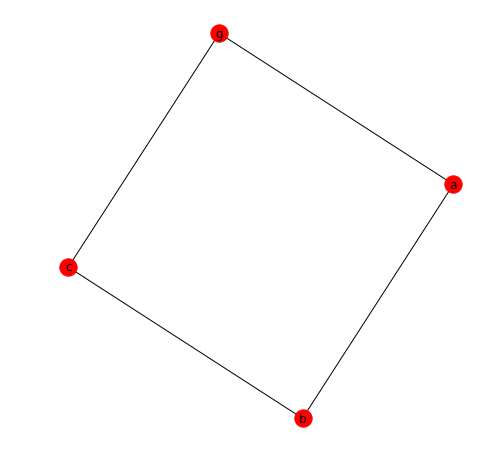

In [102]:
m.draw_topology()

In [175]:
class subsystem(object):
    
    def __init__(self,name,topology):
        self.name = name+'_'
        self.topology = topology
        def label(x):
            name = self.name + x
            return name
        self.data_graph = nx.relabel_nodes(topology.data_graph,label)
        self._virtual_bodies = []
    
    @property
    def selected_variant(self):
        return self.data_graph
    @property
    def nodes(self):
        return self.selected_variant.nodes
    @property
    def edges(self):
        return self.selected_variant.edges
    @property
    def virtual_bodies(self):
        virtual_bodies = [self.name+i for i in self.topology.virtual_bodies]
        return set(virtual_bodies)
    
    def _assemble_nodes(self):
        for n in self.nodes:
            if n.startswith(self.name+'vb'):
                pass
            else:
                body_type = self.nodes[n]['class']
                self.nodes[n]['obj'] = body_type(n)
            self.nodes[n]['mirr']=self.name+self.nodes[n]['mirr']
    
    def _assemble_edge(self,e):
        edge_class = self.edges[e]['class']
        b1, b2, name = e
        if issubclass(edge_class,joint_actuator):
            joint_name = self.edges[e]['joint_name']
            joint_object = self.edges[(b1,b2,joint_name)]['obj']
            self.edges[e]['obj'] = edge_class(name,joint_object)
        else:
            self.edges[e]['obj'] = edge_class(name,self.nodes[b1]['obj'],self.nodes[b2]['obj'])

    def _assemble_edges(self):
        for e in self.edges:
            edge_class = self.edges[e]['class']
            b1, b2, name = e
            if b1.startswith(self.name+'vb') or b2.startswith(self.name+'vb'):
                pass
            else:
                self._assemble_edge(e)
            
    def assemble_model(self):
        self._assemble_nodes()
        self._assemble_edges()
    

# Model Creation Tests

In [22]:
dwb_suspension = template_based_topology('dwb_suspension')

In [23]:
dwb_suspension.add_virtual_body('CH')
dwb_suspension.add_virtual_body('steer',mirrored=True)
dwb_suspension.add_body('uca',mirrored=True)
dwb_suspension.add_body('lca',mirrored=True)
dwb_suspension.add_body('strut_upper',mirrored=True)
dwb_suspension.add_body('strut_lower',mirrored=True)
dwb_suspension.add_body('upright',mirrored=True)
dwb_suspension.add_body('hub',mirrored=True)
dwb_suspension.add_body('tie_rod',mirrored=True)

In [24]:
dwb_suspension.add_joint(spherical,'uca_upright','rbr_uca','rbr_upright',mirrored=True)
dwb_suspension.add_joint(spherical,'lca_upright','rbr_lca','rbr_upright',mirrored=True)
dwb_suspension.add_joint(spherical,'tie_upright','rbr_tie_rod','rbr_upright',mirrored=True)

dwb_suspension.add_joint(revolute,'uca_chassis','rbr_uca','vbs_CH',mirrored=True)
dwb_suspension.add_joint(revolute,'lca_chassis','rbr_lca','vbs_CH',mirrored=True)
dwb_suspension.add_joint(revolute,'hub_bearing','rbr_upright','rbr_hub',mirrored=True)

dwb_suspension.add_joint(universal,'strut_chassis','rbr_strut_upper','vbs_CH',mirrored=True)
dwb_suspension.add_joint(universal,'strut_lca','rbr_strut_lower','rbr_lca',mirrored=True)
dwb_suspension.add_joint(universal,'tie_steering','rbr_tie_rod','vbr_steer',mirrored=True)

dwb_suspension.add_joint(cylinderical,'strut','rbr_strut_upper','rbr_strut_lower',mirrored=True)

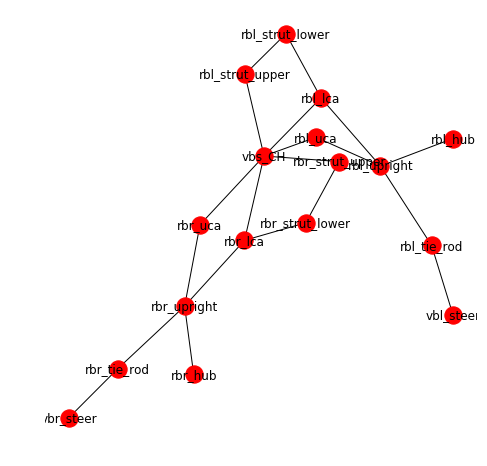

In [25]:
dwb_suspension.draw_topology()

In [223]:
steering = template_based_topology('steering')

In [224]:
steering.add_virtual_body('CH')
steering.add_body('rocker',mirrored=True)
steering.add_body('coupler')

In [225]:
steering.add_joint(revolute,'rocker_chassis','rbr_rocker','vbs_CH',mirrored=True)
steering.add_joint(spherical,'rocker_coupler_sph','rbr_rocker','rbs_coupler',mirrored=False)
steering.add_joint(cylinderical,'rocker_coupler_uni','rbl_rocker','rbs_coupler',mirrored=False)

In [226]:
steering.add_joint_actuator(rotational_actuator,'act','jcl_rocker_chassis')

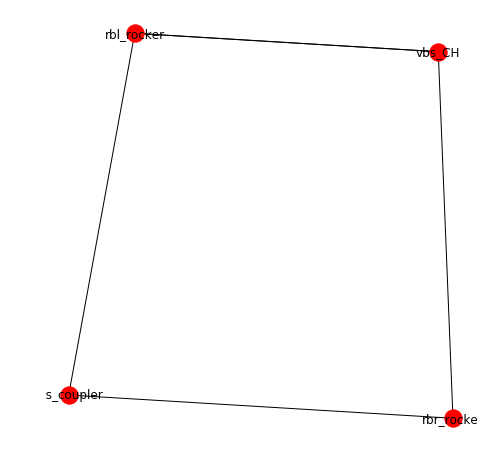

In [227]:
steering.draw_topology()

In [31]:
ax1 = subsystem('ax1',dwb_suspension)
ax1.assemble_model()

In [32]:
ax2 = subsystem('ax2',dwb_suspension)
ax2.assemble_model()

In [228]:
steering_subsystem = subsystem('front_steering',steering)
steering_subsystem.assemble_model()

In [216]:
class assembly(object):
    
    def __init__(self,name):
        self.name = name
        self.ground = ground()
        self.graph = nx.MultiGraph(name=name)
        self.graph.add_node('ground',obj=self.ground,mirr='ground')
        self.subsystems = {}
        self._virtual_bodies_map = {}
    
    @property
    def nve(self):
        nve_nodes = sum([node[-1] for node in self.nodes(data='nve')])
        nve_edges = sum([edge[-1] for edge in self.edges(data='nve')])
        return nve_nodes + nve_edges +1
    @property
    def selected_variant(self):
        return self.graph
    @property
    def nodes(self):
        return self.selected_variant.nodes
    @property
    def edges(self):
        return self.selected_variant.edges
    @property
    def virtual_bodies_map(self):
        return self._virtual_bodies_map
    
    def _update_virtual_bodies_map(self,subsystem):
        new_virtuals = subsystem.virtual_bodies
        new_virtuals = zip(new_virtuals,len(new_virtuals)*['ground'])
        self._virtual_bodies_map.update(new_virtuals)
    
    def _replace_nodes(self,v,u):
        nx.relabel_nodes(self.graph,{v:u},copy=False)
        
    def add_subsystem(self,subsystem):
        self.subsystems[subsystem.name] = subsystem
        subsystem_graph = subsystem.selected_variant
        self.graph.add_nodes_from(subsystem_graph.nodes(data=True))
        self.graph.add_edges_from(subsystem_graph.edges(data=True,keys=True))
        self._update_virtual_bodies_map(subsystem)
    
    def assign_virtual_body(self,virtual_node,actual_node):
        virtual_node_1 = virtual_node
        virtual_node_2 = self.nodes[virtual_node]['mirr']
        actual_node_1 = actual_node
        actual_node_2 = self.nodes[actual_node]['mirr']
        self.virtual_bodies_map[virtual_node_1] = actual_node_1
        self.virtual_bodies_map[virtual_node_2] = actual_node_2
    
    def assemble_model(self):
        for v,u in self.virtual_bodies_map.items():
            self._replace_nodes(v,u)
    
    def _assemble_edge(self,e):
        edge_class = self.edges[e]['class']
        b1, b2, name = e
        if issubclass(edge_class,joint_actuator):
            joint_name = self.edges[e]['joint_name']
            joint_object = self.edges[(b1,b2,joint_name)]['obj']
            self.edges[e]['obj'] = edge_class(name,joint_object)
        else:
            self.edges[e]['obj'] = edge_class(name,self.nodes[b1]['obj'],self.nodes[b2]['obj'])

    
    
    def draw_topology(self):
        plt.figure(figsize=(8,8))
        nx.draw_spring(self.graph,with_labels=True)
        plt.show()
    
    def generate_equations(self):
        
        edgelist = self.edges
        nodelist = self.nodes
        node_index = dict([(n,i) for i,n in enumerate(nodelist)])

        n_nodes = len(nodelist)
        cols = 2*n_nodes
        
        nve = self.nve  # number of constraint vector equations
        
        jacobian = sm.MutableSparseMatrix(nve,cols,None)
        
        equations = sm.MutableSparseMatrix(nve,1,None)
        vel_rhs   = sm.MutableSparseMatrix(nve,1,None)
        acc_rhs   = sm.MutableSparseMatrix(nve,1,None)
        
        row_ind = 0
        for e in edgelist:
            u,v = e[:2]
            try:
                eo  = self.edges[e]['obj'] # joint object
            except KeyError:
                self._assemble_edge(e)
                eo  = self.edges[e]['obj'] # joint object
            
            # tracker of row index based on the current joint type and the history
            # of the loop
            eo_nve = eo.nve+row_ind 
            
            ui = node_index[u]
            vi = node_index[v]
            
            # assigning the joint jacobians to the propper index in the system jacobian
            # on the "constraint vector equations" level.
            jacobian[row_ind:eo_nve,ui*2:ui*2+2] = eo.jacobian_i.blocks
            jacobian[row_ind:eo_nve,vi*2:vi*2+2] = eo.jacobian_j.blocks
            
            equations[row_ind:eo_nve,0] = eo.pos_level_equations.blocks
            vel_rhs[row_ind:eo_nve,0] = eo.vel_level_equations.blocks
            acc_rhs[row_ind:eo_nve,0] = eo.acc_level_equations.blocks
           
            row_ind += eo.nve
        
        
        for i,n in enumerate(nodelist):
            b = self.nodes[n]['obj']
            if isinstance(b,ground):
                jacobian[row_ind:row_ind+2,i*2:i*2+2]    = b.normalized_jacobian.blocks
                equations[row_ind:row_ind+2,0] = b.normalized_pos_equation.blocks
                vel_rhs[row_ind:row_ind+2,0]   = b.normalized_vel_equation.blocks
                acc_rhs[row_ind:row_ind+2,0]   = b.normalized_acc_equation.blocks
            else:
                jacobian[row_ind,i*2+1] = b.normalized_jacobian[1]
                equations[row_ind,0] = b.normalized_pos_equation
                vel_rhs[row_ind,0]   = b.normalized_vel_equation
                acc_rhs[row_ind,0]   = b.normalized_acc_equation
                
            row_ind += b.nve
        
        self.pos_level_equations = equations
        self.vel_level_equations = vel_rhs
        self.acc_level_equations = acc_rhs
        self.jacobian = jacobian
    
    
    
    @property
    def configuration_constants(self):
        cons = []
        for e in self.edges(data='obj'):
            cons += e[-1].configuration_constants()
        return cons
    @property
    def numerical_arguments(self):
        cons = []
        for e in self.edges(data='obj'):
            cons += e[-1].numerical_arguments()
        for n in self.nodes(data='obj'):
            cons += n[-1].numerical_arguments()
        return cons
    @property
    def q(self):
        return sm.MatrixSymbol('q',7*len(self.nodes),1)
    @property
    def qd(self):
        return sm.MatrixSymbol('qd',7*len(self.nodes),1)
    def map_coordinates(self):
        q = []
        qd = []
        i = 0
        for n in self.nodes(data='obj'):
            q.append(sm.Eq(n[-1].R,self.q[i:i+3,0]))
            q.append(sm.Eq(n[-1].P,self.q[i+3:i+3+4,0]))
            
            qd.append(sm.Eq(n[-1].Rd,self.qd[i:i+3,0]))
            qd.append(sm.Eq(n[-1].Pd,self.qd[i+3:i+3+4,0]))
            
            i+=7
        self.q_maped = q
        self.qd_maped = qd

In [229]:
steering_assembly = assembly('steering')

In [230]:
steering_assembly.add_subsystem(steering_subsystem)

In [231]:
steering_assembly.assemble_model()

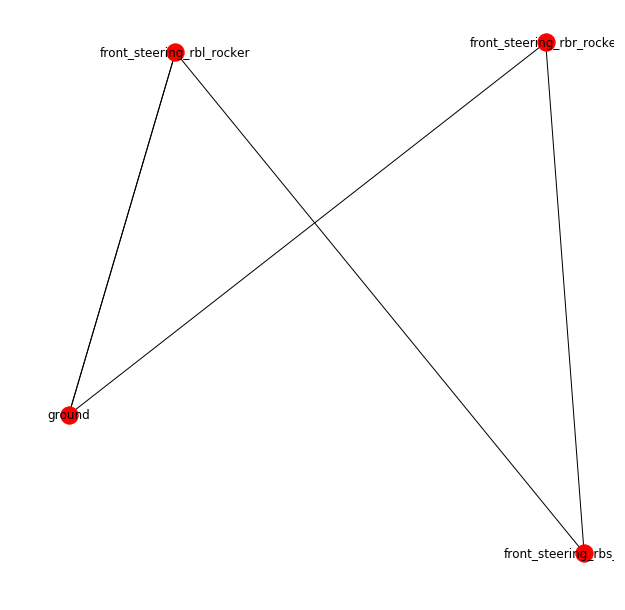

In [232]:
steering_assembly.draw_topology()

In [241]:
steering_assembly.generate_equations()

In [234]:
steering_assembly.nve

In [242]:
steering_assembly.pos_level_equations

Matrix([
[                                                                                                                                                                                      -{R_{front_steering_rbr_rocker}} + A({P_{ground}})*{\bar{u}^{ground}_{jcr_rocker_chassis}} - A({P_{front_steering_rbr_rocker}})*{\bar{u}^{front_steering_rbr_rocker}_{jcr_rocker_chassis}} + {R_{ground}}],
[                                                                                                                                                                                                                  {\bar{M}^{ground}_{jcr_rocker_chassis}}[:,(0, 1)].T*A({P_{ground}}).T*A({P_{front_steering_rbr_rocker}})*{\bar{M}^{front_steering_rbr_rocker}_{jcr_rocker_chassis}}[:,(2, 3)]],
[                                                                                                                                                                                                                  {\bar{

In [243]:
ccode_print = False
steering_assembly.jacobian

Matrix([
[               I,                                                                                                                       B({P_{ground}}, {\bar{u}^{ground}_{jcr_rocker_chassis}}),               -I,                                                                                -B({P_{front_steering_rbr_rocker}}, {\bar{u}^{front_steering_rbr_rocker}_{jcr_rocker_chassis}}),                                                                                                                0,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [236]:
steering_assembly.map_coordinates()
steering_assembly.q_maped

# Code Printers

In [37]:
enclose = True
from sympy.printing.codeprinter import CodePrinter
class numerical_printer(C99CodePrinter):

    
    '''def _print_Symbol(self,expr):
        return expr.name
    '''
    
    def _print_ZeroMatrix(self,expr):
        return 'np.zeros(%s,dtype=np.float64)'%(expr.shape)
    
    def _print_zero_matrix(self,expr):
        return 'np.zeros(%s,dtype=np.float64)'%(expr.shape)
    
    '''def _print_base_vactor(self,expr):
        global enclose
        if enclose :
            return '%r'%expr._raw_name
        else:
            return '%s'%expr._raw_name'''
    
    def _print_AbstractMatrix(self,expr):
        args = [self._print(i) for i in expr.args]
        name = expr.__class__.__name__
        
        if len(args) ==1:
            return '%s(%s)'%(name,args[0])
        else:
            return '%s%s'%(name,(*args,))
    
    def _print_B(self,expr):
        p, u = expr.args
        return 'B(%s,%s)'%(self._print(p),self._print(u))
    
    '''
    def _print_A(self,expr):
        p = expr.args[0]
        return 'A(%s)'%self._print(p)'''
    
    
    def _print_dcm(self,expr):
        global enclose
        if enclose :
            return '%r'%expr._raw_name
        else:
            return '%s'%expr._raw_name
    
    
    def _print_vector(self,expr):
        global enclose
        if enclose :
            return '%r'%expr._raw_name
        else:
            return '%s'%expr._raw_name
    
    def _print_quatrenion(self,expr):
        global enclose
        if enclose :
            return '%r'%expr._raw_name
        else:
            return '%s'%expr._raw_name
    
    def _print_Mul(self,expr):
        return '*'.join([self._print(i) for i in expr.args])
    
    def _print_MatMul(self,expr):
        scalars = []
        vectors = []
        express = []
        args = expr.args
        
        for i in args:
            #print(i)
            if isinstance(i,sm.MatrixExpr) and not isinstance(i,sm.MatMul):
                #print('vector: %s'%i)
                #print(type(i))
                vectors.append(self._print(i))
            elif isinstance(i,sm.MatMul):
                #print('MatMul: %s'%i)
                vectors.append(self._print_MatMul(i))
            elif isinstance(i,sm.Number):
                #print('Scalar: %s'%i)
                scalars.append(str(float(i)))
            else:
                #print('Expression: %s'%i)
                express.append(self._print(i))
        
        if len(scalars)==0:
            s = ''
        else:
            s = '*'.join(scalars)+'*'
            
        if len(vectors)>1:
            v = 'multi_dot([%s])'%','.join(vectors)
        else:
            v = str(vectors[0])
            
        if len(express)==0:
            e = ''
        else:
            e = '*'.join(express)+'*'
        #print('end \n')
        return e + s + v 
        

    '''def _print_Matrix(self,expr):
        return 'np.array(%s)'%(expr.tolist())'''
    
    def _print_Identity(self,expr):
        shape = expr.args[0]
        return 'np.eye(%s,dtype=np.float64)'%shape
    
    def _print_MatExpr(self,expr):
        return '%s'%expr._ccode()
    
    
    def _print_tuple(self,expr):
        if len(expr)>2:
            return super()._print_tuple(expr)
        else:
            return str(expr[0]) + ' = ' + self._print(expr[1])
    
    def _print_Equality(self,expr):
        args = expr.args
        return str(args[0]) + ' = ' + self._print(args[1])
    
    def _print_MatAdd(self,expr):
        nested_operations = [self._print(i) for i in expr.args]
        value = ' + '.join(nested_operations)
        return '(%s)'%value
    
    def _print_BlockMatrix(self,expr):
        blocks = []
        rows,cols = expr.blockshape
        for r in np.arange(rows):
            row = []
            for c in np.arange(cols):
                row.append(self._print(expr.blocks[r,c]))
            string = ','.join(row)
            blocks.append('[%s]'%string)
        return 'np.bmat([%s])'%(','.join(blocks))
    
    def _print_MatrixSlice(self,expr):
        m, row_slice, col_slice = expr.args
        return f'{m}[{row_slice[0]}:{row_slice[1]},{col_slice[0]}:{col_slice[1]}]'
    
    def _print_MutableDenseMatrix(self,expr):
        elements = expr.tolist()
        return 'np.array(%s,dtype=np.float64)'%(elements)
    
    def _print_ImmutableDenseMatrix(self,expr):
        elements = expr.tolist()
        return 'np.array(%s,dtype=np.float64)'%(elements)
    
    def _print_MutableSparseMatrix(self,expr):
        rows = []
        cols = []
        data = []
        for i,j,v in expr.row_list():
            rows.append(i)
            cols.append(j)
            data.append(v)
        
        rows_print = 'np.array([' + ','.join([self._print(i) for i in rows]) + '])'
        cols_print = 'np.array([' + ','.join([self._print(i) for i in cols]) + '])'
        data_print = '[' + ','.join([self._print(i) for i in data]) + ']'
        code_block = '\n'.join([self._print(i) for i in [rows_print,cols_print,data_print]])
        return code_block

    def _print_Derivative(self,expr):
        return 'derivative(F,t,0.1,%s)'%expr.args[1][1]
    
    def _print_Function(self,expr):
        return str(expr)
        

# Code Generators

### Numpy/Scipy Code Generator

In [276]:
import textwrap
class python_generator(object):
    global ccode_print
    global enclose
    ccode_print = True
    enclose = True
    
    def __init__(self,assembled_model,printer=numerical_printer()):
        
        self.assembly = assembled_model
        self.graph = assembled_model.graph.copy()
        self.printer = printer
        
        self.numerical_arguments = [printer._print(e.lhs) for e in self.assembly.numerical_arguments]
        self.configuration_constants = [printer._print(e.lhs) for e in self.assembly.configuration_constants]
        
        #self.configuration_coordinates = '\n'.join([printer._print(e) for e in self.assembly.numerical_arguments])
        
        self.generalized_coordinates_equalities = self.assembly.q_maped.copy()
        self.generalized_velocities_equalities = self.assembly.qd_maped.copy()
        
        self.generalized_coordinates_lhs = [printer._print(exp.lhs) for exp in self.generalized_coordinates_equalities]
        self.generalized_velocities_lhs = [printer._print(exp.lhs) for exp in self.generalized_velocities_equalities]

    
    def write_imports(self):
        text = '''
                import numpy as np
                import scipy as sc
                from numpy.linalg import multi_dot
                from matrix_funcs import A, B, sparse_assembler, triad as Triad
                from scipy.misc import derivative
                from numpy import cos, sin
                '''
        text = text.expandtabs()
        text = textwrap.dedent(text)
        return text
    
    def write_config_inputs(self):
        text = '''
                class inputs(object):

                    def __init__(self):
                        {declared_inputs}
                '''
        
        p = self.printer
        indent = 8*' '
        typing_prefix = 'self.'
        
        inputs = self.assembly.numerical_arguments
        
        self.inputs_equalities = [p._print(exp) for exp in inputs]
        self.inputs_variables  = [p._print(exp.lhs) for exp in inputs]
        declared_inputs  = '\n'.join([typing_prefix + i for i in self.inputs_equalities])
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        declared_inputs = textwrap.indent(declared_inputs,indent).lstrip()
        text = text.format(declared_inputs = declared_inputs)
        
        return text
    
    def write_coordinates_setter(self):
        text = '''
                def set_coordinates(self,q):
                    {maped}
                    
               '''
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 4*' '
        
        maped_coordinates = '\n'.join(['self.' + p._print(i) for i in self.assembly.q_maped])
        maped_coordinates = textwrap.indent(maped_coordinates,indent).lstrip()
        text = text.format(maped = maped_coordinates)
        return text
    
    def write_velocities_setter(self):
        text = '''
                def set_velocities(self,qd):
                    {maped}
                    
               '''
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 4*' '
        
        maped_coordinates = '\n'.join(['self.' + p._print(i) for i in self.assembly.qd_maped])
        maped_coordinates = textwrap.indent(maped_coordinates,indent).lstrip()
        text = text.format(maped = maped_coordinates)
        return text
    
    def write_initial_configuration_setter(self):
        text = '''
                def set_initial_configuration(self):
                    config = self.config
                    
                    q = np.concatenate([{coordinates}])
                    
                    qd = np.concatenate([{velocities}])
                    
                    self.set_coordinates(q)
                    self.set_velocities(qd)
                    self.q_initial = q.copy()
                    
               '''
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 4*' '
        
        coordinates = ',\n'.join(self.generalized_coordinates_lhs)
        for exp in self.generalized_coordinates_lhs:
            coordinates = coordinates.replace(exp,'config.'+exp[1:-1])
        coordinates = textwrap.indent(coordinates,indent).lstrip()
        
        velocities = ',\n'.join(self.generalized_velocities_lhs)
        for exp in self.generalized_velocities_lhs:
            velocities = velocities.replace(exp,'config.'+exp[1:-1])
        velocities = textwrap.indent(velocities,indent).lstrip()
        
        text = text.format(coordinates = coordinates,
                           velocities  = velocities)
        return text
    
    def write_assembly_class(self):
        text = '''
                class numerical_assembly(object):

                    def __init__(self,config):
                    
                        self.config = config
                        self.Pg_ground = np.array([[1], [0], [0], [0]],dtype=np.float64)
                        
                        {pos_rows}
                        {pos_cols}
                        
                        {vel_rows}
                        {vel_cols}
                        
                        {acc_rows}
                        {acc_cols}
                        
                        {jac_rows}
                        {jac_cols}
                    
                    def eval_constants(self):
                        config = self.config
                        
                        {cse_variables}

                        {cse_expressions}
                    
                    {coord_setter}
                    {velocities_setter}
                    {initial_config_setter}
                    
                    {eval_pos}
                    
                    {eval_vel}
                    
                    {eval_acc}
                    
                    {eval_jac}
                    
                '''
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 8*' '
        
        configuration_constants = self.assembly.configuration_constants
        
        constants_cse = sm.cse(configuration_constants,symbols=sm.iterables.numbered_symbols('c'))
        cse_variables = '\n'.join([p._print(exp) for exp in constants_cse[0]])
        cse_expressions  = '\n'.join(['self.' + p._print(exp) for exp in constants_cse[1]])

        for exp in self.numerical_arguments:
            cse_variables = cse_variables.replace(exp,'config.'+exp[1:-1])
            
        cse_variables   = textwrap.indent(cse_variables,indent).lstrip()
        cse_expressions = textwrap.indent(cse_expressions,indent).lstrip()
        
        coord_setter = self.write_coordinates_setter()
        velocities_setter = self.write_velocities_setter()
        initial_config_setter = self.write_initial_configuration_setter()
        
        eval_pos = self.write_pos_level_eq()
        eval_vel = self.write_vel_level_eq()
        eval_acc = self.write_acc_level_eq()
        eval_jac = self.write_jacobian()
        
        text = text.format(cse_variables = cse_variables,
                           cse_expressions = cse_expressions,
                           pos_rows = self.pos_level_rows,
                           pos_cols = self.pos_level_cols,
                           vel_rows = self.vel_level_rows,
                           vel_cols = self.vel_level_cols,
                           acc_rows = self.acc_level_rows,
                           acc_cols = self.acc_level_cols,
                           jac_rows = self.jacobian_rows,
                           jac_cols = self.jacobian_cols,
                           eval_pos = eval_pos,
                           eval_vel = eval_vel,
                           eval_acc = eval_acc,
                           eval_jac = eval_jac,
                           coord_setter = coord_setter,
                           velocities_setter = velocities_setter,
                           initial_config_setter = initial_config_setter)
        
        return text
    
    def write_pos_level_eq(self):
        
        text = '''
                def eval_pos_eq(self):

                    {cse_variables}

                    {pos_level_data}
                    
                    self.pos_level_rows_explicit = []
                    self.pos_level_cols_explicit = []
                    self.pos_level_data_explicit = []
                    
                    sparse_assembler(self.pos_level_data_blocks, self.pos_level_rows_blocks, self.pos_level_cols_blocks,
                                     self.pos_level_data_explicit, self.pos_level_rows_explicit, self.pos_level_cols_explicit)
                '''
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 4*' '
        
        pos_level_equations = self.assembly.pos_level_equations
        
        cse_symbols = sm.iterables.numbered_symbols('x')
        cse = sm.cse(pos_level_equations,symbols=cse_symbols)
        cse_variables   = '\n'.join([p._print(exp) for exp in cse[0]])
        cse_expressions = '\n'.join([p._print(exp) for exp in cse[1]])

        
        for exp in self.generalized_coordinates_lhs:
            cse_variables = cse_variables.replace(exp,'self.'+exp[1:-1])
            cse_expressions = cse_expressions.replace(exp,'self.'+exp[1:-1])
        for exp in self.configuration_constants:
            cse_variables = cse_variables.replace(exp,'self.'+exp[1:-1])
            cse_expressions = cse_expressions.replace(exp,'self.'+exp[1:-1])
        
        cse_variables = textwrap.indent(cse_variables,indent).lstrip() 
        cse_expressions = textwrap.indent(cse_expressions,indent).lstrip()
        
        rows,cols,data = p._print(cse_expressions).split('\n')
        
        self.pos_level_rows = 'self.pos_level_rows_blocks = %s'%rows.lstrip()
        self.pos_level_cols = 'self.pos_level_cols_blocks = %s'%cols.lstrip()
        data = 'self.pos_level_data_blocks = %s'%data.lstrip()
        
        text = text.format(cse_variables  = cse_variables,
                           pos_level_data = data)
        
        return text
    
    def write_vel_level_eq(self):
        
        text = '''
                def eval_vel_eq(self):

                    {cse_variables}

                    {vel_level_data}
                    
                    self.vel_level_rows_explicit = []
                    self.vel_level_cols_explicit = []
                    self.vel_level_data_explicit = []
                    
                    sparse_assembler(self.vel_level_data_blocks, self.vel_level_rows_blocks, self.vel_level_cols_blocks,
                                     self.vel_level_data_explicit, self.vel_level_rows_explicit, self.vel_level_cols_explicit)
                '''
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 4*' '
        
        vel_level_equations = self.assembly.vel_level_equations
        
        cse_symbols = sm.iterables.numbered_symbols('x')
        cse = sm.cse(vel_level_equations,symbols=cse_symbols)
        cse_variables   = '\n'.join([p._print(exp) for exp in cse[0]])
        cse_expressions = '\n'.join([p._print(exp) for exp in cse[1]])

        
        for exp in self.generalized_coordinates_lhs:
            cse_variables = cse_variables.replace(exp,'self.'+exp[1:-1])
            cse_expressions = cse_expressions.replace(exp,'self.'+exp[1:-1])
        for exp in self.configuration_constants:
            cse_variables = cse_variables.replace(exp,'self.'+exp[1:-1])
            cse_expressions = cse_expressions.replace(exp,'self.'+exp[1:-1])
        
        cse_variables = textwrap.indent(cse_variables,indent).lstrip() 
        cse_expressions = textwrap.indent(cse_expressions,indent).lstrip()
        
        rows,cols,data = p._print(cse_expressions).split('\n')
        
        self.vel_level_rows = 'self.vel_level_rows_blocks = %s'%rows.lstrip()
        self.vel_level_cols = 'self.vel_level_cols_blocks = %s'%cols.lstrip()
        data = 'self.vel_level_data_blocks = %s'%data.lstrip()
        
        text = text.format(cse_variables  = cse_variables,
                           vel_level_data = data)
        
        return text
    
    def write_jacobian(self):
        
        text = '''
                def eval_jacobian(self):

                    {cse_variables}

                    {jacobian_data}
                    
                    self.jacobian_rows_explicit = []
                    self.jacobian_cols_explicit = []
                    self.jacobian_data_explicit = []
                    
                    sparse_assembler(self.jacobian_data_blocks, self.jacobian_rows_blocks, self.jacobian_cols_blocks,
                                     self.jacobian_data_explicit, self.jacobian_rows_explicit, self.jacobian_cols_explicit)
                '''
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 4*' '
        
        generalized_coord  = self.assembly.q_maped
        jacobian = self.assembly.jacobian
        
        cse_symbols = sm.iterables.numbered_symbols('j')
        cse = sm.cse(jacobian,symbols=cse_symbols)
        cse_variables   = '\n'.join([p._print(exp) for exp in cse[0]])
        cse_expressions = '\n'.join([p._print(exp) for exp in cse[1]])

        
        for exp in self.generalized_coordinates_lhs:
            cse_variables = cse_variables.replace(exp,'self.'+exp[1:-1])
            cse_expressions = cse_expressions.replace(exp,'self.'+exp[1:-1])
        for exp in self.configuration_constants:
            cse_variables = cse_variables.replace(exp,'self.'+exp[1:-1])
            cse_expressions = cse_expressions.replace(exp,'self.'+exp[1:-1])
        
        cse_variables = textwrap.indent(cse_variables,indent).lstrip()  
        cse_expressions = textwrap.indent(cse_expressions,indent).lstrip()
        
        rows,cols,data = p._print(cse_expressions).split('\n')
        
        self.jacobian_rows = ('self.jacobian_rows_blocks = %s'%rows.lstrip())
        self.jacobian_cols = ('self.jacobian_cols_blocks = %s'%cols.lstrip())
        data = ('self.jacobian_data_blocks = %s'%data.lstrip())
        
        text = text.format(cse_variables = cse_variables,
                           jacobian_data = data)
        
        return text
    
    def write_acc_level_eq(self):
        
        text = '''
                def eval_acc_eq(self):

                    {cse_variables}

                    {acc_level_data}
                    
                    self.acc_level_rows_explicit = []
                    self.acc_level_cols_explicit = []
                    self.acc_level_data_explicit = []
                    
                    sparse_assembler(self.acc_level_data_blocks, self.acc_level_rows_blocks, self.acc_level_cols_blocks,
                                     self.acc_level_data_explicit, self.acc_level_rows_explicit, self.acc_level_cols_explicit)
                '''
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 4*' '
        
        acc_level_equations = self.assembly.acc_level_equations
        
        cse_symbols = sm.iterables.numbered_symbols('a')
        cse = sm.cse(acc_level_equations,symbols=cse_symbols)
        cse_variables   = '\n'.join([p._print(exp) for exp in cse[0]])
        cse_expressions = '\n'.join([p._print(exp) for exp in cse[1]])

        
        for exp in self.generalized_velocities_lhs+self.generalized_coordinates_lhs:
            cse_variables = cse_variables.replace(exp,'self.'+exp[1:-1])
            cse_expressions = cse_expressions.replace(exp,'self.'+exp[1:-1])
        for exp in self.configuration_constants:
            cse_variables = cse_variables.replace(exp,'self.'+exp[1:-1])
            cse_expressions = cse_expressions.replace(exp,'self.'+exp[1:-1])
        
        cse_variables = textwrap.indent(cse_variables,indent).lstrip()  
        cse_expressions = textwrap.indent(cse_expressions,indent).lstrip()
        
        rows,cols,data = p._print(cse_expressions).split('\n')
        
        self.acc_level_rows = 'self.acc_level_rows_blocks = %s'%rows.lstrip()
        self.acc_level_cols = 'self.acc_level_cols_blocks = %s'%cols.lstrip()
        data = 'self.acc_level_data_blocks = %s'%data.lstrip()
        
        text = text.format(cse_variables  = cse_variables,
                           acc_level_data = data)
        
        return text
    
    
    def dump_code(self):
        imports = self.write_imports()
        inputs  = self.write_config_inputs()
        constants = self.write_config_constants()
        topology  = self.write_topology_calss()
        variant   = self.write_variant_calss()
        
        text = '\n'.join([imports,inputs,constants,topology,variant])
        return text
        

## Pendulum Example

In [314]:
pendulum_template = template_based_topology('pendulum')

In [315]:
pendulum_template.add_body('pendulum')
pendulum_template.add_virtual_body('ground')
pendulum_template.add_joint(revolute,'h','rbs_pendulum','vbs_ground')
pendulum_template.add_joint_actuator(rotational_actuator,'act','jcs_h')

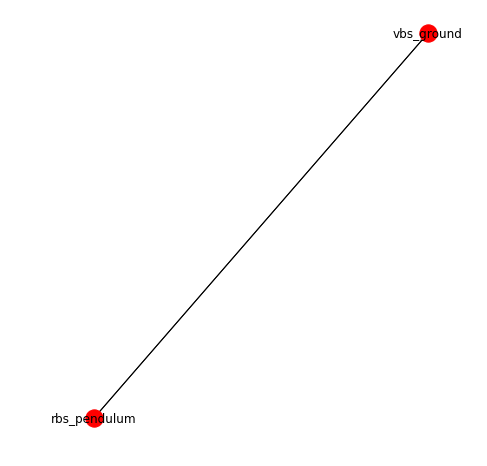

In [316]:
pendulum_template.draw_topology()

In [317]:
pendulum_subsystem = subsystem('pen',pendulum_template)
pendulum_subsystem.assemble_model()

In [318]:
pendulum_assembly = assembly('pend')

In [319]:
pendulum_assembly.add_subsystem(pendulum_subsystem)
pendulum_assembly.assemble_model()
pendulum_assembly.generate_equations()
pendulum_assembly.map_coordinates()
pendulum_assembly.q_maped

In [320]:
pendulum_assembly.pos_level_equations

Matrix([
[      -R_pen_rbs_pendulum + A(P_ground)*ubar_ground_jcs_h - A(P_pen_rbs_pendulum)*ubar_pen_rbs_pendulum_jcs_h + R_ground],
[                 Mbar_ground_jcs_h[:,(0, 1)].T*A(P_ground).T*A(P_pen_rbs_pendulum)*Mbar_pen_rbs_pendulum_jcs_h[:,(2, 3)]],
[                 Mbar_ground_jcs_h[:,(1, 2)].T*A(P_ground).T*A(P_pen_rbs_pendulum)*Mbar_pen_rbs_pendulum_jcs_h[:,(2, 3)]],
[(-sin(F(t)))*I + Mbar_ground_jcs_h[:,(0, 1)].T*A(P_ground).T*A(P_pen_rbs_pendulum)*Mbar_pen_rbs_pendulum_jcs_h[:,(1, 2)]],
[                                                                                                                R_ground],
[                                                                                                   -Pg_ground + P_ground],
[                                                                   -I + (P_pen_rbs_pendulum.T*P_pen_rbs_pendulum)**(1/2)]])

In [321]:
pendulum_assembly.jacobian

Matrix([
[               I,                                                                           B(P_ground, ubar_ground_jcs_h),               -I,                                                      -B(P_pen_rbs_pendulum, ubar_pen_rbs_pendulum_jcs_h)],
[zero_matrix(1,3), Mbar_pen_rbs_pendulum_jcs_h[:,(2, 3)].T*A(P_pen_rbs_pendulum).T*B(P_ground, Mbar_ground_jcs_h[:,(0, 1)]), zero_matrix(1,3), Mbar_ground_jcs_h[:,(0, 1)].T*A(P_ground).T*B(P_pen_rbs_pendulum, Mbar_pen_rbs_pendulum_jcs_h[:,(2, 3)])],
[zero_matrix(1,3), Mbar_pen_rbs_pendulum_jcs_h[:,(2, 3)].T*A(P_pen_rbs_pendulum).T*B(P_ground, Mbar_ground_jcs_h[:,(1, 2)]), zero_matrix(1,3), Mbar_ground_jcs_h[:,(1, 2)].T*A(P_ground).T*B(P_pen_rbs_pendulum, Mbar_pen_rbs_pendulum_jcs_h[:,(2, 3)])],
[zero_matrix(1,3), Mbar_pen_rbs_pendulum_jcs_h[:,(1, 2)].T*A(P_pen_rbs_pendulum).T*B(P_ground, Mbar_ground_jcs_h[:,(0, 1)]), zero_matrix(1,3), Mbar_ground_jcs_h[:,(0, 1)].T*A(P_ground).T*B(P_pen_rbs_pendulum, Mbar_pen_rbs_pendulum_jcs_h[:,(1

In [322]:
pendulum_generator = python_generator(pendulum_assembly)

In [324]:
print(pendulum_generator.write_assembly_class())


class numerical_assembly(object):

    def __init__(self,config):

        self.config = config
        self.Pg_ground = np.array([[1], [0], [0], [0]],dtype=np.float64)

        self.pos_level_rows_blocks = np.array([0,1,2,3,4,5,6])
        self.pos_level_cols_blocks = np.array([0,0,0,0,0,0,0])

        self.vel_level_rows_blocks = np.array([0,1,2,3,4,5,6])
        self.vel_level_cols_blocks = np.array([0,0,0,0,0,0,0])

        self.acc_level_rows_blocks = np.array([0,1,2,3,4,5,6])
        self.acc_level_cols_blocks = np.array([0,0,0,0,0,0,0])

        self.jacobian_rows_blocks = np.array([0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,5,5,6])
        self.jacobian_cols_blocks = np.array([0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,0,1,3])

    def eval_constants(self):
        config = self.config

        c0 = A(config.P_ground).T
        c1 = config.pt_jcs_h
        c2 = A(config.P_pen_rbs_pendulum).T
        c3 = Triad(config.ax_jcs_h)

        self.ubar_ground_jcs_h = (multi_dot([c0,c1]) + -1.0*mul

## FourBar Exammple

In [336]:
fourbar_template = template_based_topology('fourbar')

In [337]:
fourbar_template.add_body('l1')
fourbar_template.add_body('l2')
fourbar_template.add_body('l3')
fourbar_template.add_virtual_body('ground')

In [338]:
fourbar_template.add_joint(revolute,'a','vbs_ground','rbs_l1')
fourbar_template.add_joint(revolute,'d','vbs_ground','rbs_l3')
fourbar_template.add_joint(spherical,'b','rbs_l1','rbs_l2')
fourbar_template.add_joint(universal,'c','rbs_l2','rbs_l3')
fourbar_template.add_joint_actuator(rotational_actuator,'act','jcs_a')

In [339]:
fourbar_subsystem = subsystem('sub',fourbar_template)
fourbar_subsystem.assemble_model()

In [340]:
fourbar_assembly = assembly('assm')
fourbar_assembly.add_subsystem(fourbar_subsystem)
fourbar_assembly.assemble_model()
fourbar_assembly.generate_equations()
fourbar_assembly.map_coordinates()
fourbar_assembly.q_maped

In [342]:
fourbar_generator = python_generator(fourbar_assembly)
print(fourbar_generator.write_assembly_class())


class numerical_assembly(object):

    def __init__(self,config):

        self.config = config
        self.Pg_ground = np.array([[1], [0], [0], [0]],dtype=np.float64)

        self.pos_level_rows_blocks = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
        self.pos_level_cols_blocks = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

        self.vel_level_rows_blocks = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
        self.vel_level_cols_blocks = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

        self.acc_level_rows_blocks = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
        self.acc_level_cols_blocks = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

        self.jacobian_rows_blocks = np.array([0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,11,11,12,13,14])
        self.jacobian_cols_blocks = np.array([0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,6,7,0,1,6,7,0,1,6,7,2,3,4,5,4,5,6,7,4,5,6,7,0,1,0,1,3,5,7])

    def eval_constants(self):
        config 

### Cython Code Generator

In [72]:
import textwrap
class cython_generator(object):
    global ccode_print
    global enclose
    ccode_print = True
    enclose = True
    
    def __init__(self,func_topology,printer=cython_printer()):
        
        self.functional_topology = func_topology
        self.topology_variant = func_topology.base_topology
        self.printer = printer
        
    def set_variant(self,variant_name):
        variant = self.functional_topology.variants[variant_name]
        self.topology_variant = variant
    
    
    def creat_subclassed_variant(self,base_variant_name,other_variant):
        pass
    
    
    def write_imports(self):
        text = '''
                cimport cython
                cimport numpy as cnp

                import numpy as np
                import scipy as sc
                from numpy.linalg import multi_dot
                from matrix_funcs cimport A, B, sparse_assembler, triad as Triad
                '''
        text = text.expandtabs()
        text = textwrap.dedent(text)
        return text
    
    def write_config_inputs(self):
        text = '''
                cdef class inputs:
                
                    {declared_inputs}

                    def __init__(self):
                        pass
                '''
        
        p = self.printer
        indent = 4*' '
        typing_prefix = 'cdef public cnp.ndarray '
        
        inputs = self.functional_topology.inputs
        
        self.inputs_list = [p._print(exp.lhs) for exp in inputs]
        declared_inputs  = '\n'.join([typing_prefix + i[1:-1] for i in self.inputs_list])
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        declared_inputs = textwrap.indent(declared_inputs,indent).lstrip()
        text = text.format(declared_inputs = declared_inputs)
        
        return text
    
    def write_config_constants(self):
        text = '''
                cdef class constants:

                    {declared_constants}

                    def __init__(self,inputs config):

                        {cse_variables}

                        {cse_expressions}
                '''
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 4*' '
        typing_prefix = 'cdef cnp.ndarray '
        
        constants = self.topology_variant.constants
        
        self.constants_list = [p._print(exp.lhs) for exp in constants]
        declared_constants = '\n'.join([typing_prefix + i[1:-1] for i in self.constants_list])
        declared_constants = textwrap.indent(declared_constants,indent).lstrip()
        
        constants_cse = sm.cse(constants,symbols=sm.iterables.numbered_symbols('c'))
        cse_variables = '\n'.join([typing_prefix + p._print(exp) for exp in constants_cse[0]])
        cse_expressions  = '\n'.join(['self.' + p._print(exp) for exp in constants_cse[1]])

        self.prefixed_inputs = []
        for i,exp in enumerate(self.inputs_list):
            self.prefixed_inputs.append('config.'+exp[1:-1])
            cse_variables = cse_variables.replace(exp,self.prefixed_inputs[i])
        cse_variables = textwrap.indent(cse_variables,2*indent).lstrip()
        
        cse_expressions = textwrap.indent(cse_expressions,2*indent).lstrip()
        
        text = text.format(declared_constants = declared_constants,
                           cse_variables = cse_variables,
                           cse_expressions = cse_expressions)
        
        return text
    
    def write_topology_calss(self):
        text = '''
                cdef class topology:

                    {declared_generalized_coord}
                    
                    {declared_velocities}

                    cdef constants cons
                    
                    cdef cnp.ndarray pos_level_rows_blocks
                    cdef cnp.ndarray pos_level_cols_blocks
                    cdef list pos_level_data_blocks
                    
                    cdef cnp.ndarray jacobian_rows_blocks
                    cdef cnp.ndarray jacobian_cols_blocks
                    cdef list jacobian_data_blocks
                    
                    cdef cnp.ndarray acc_level_rows_blocks
                    cdef cnp.ndarray acc_level_cols_blocks
                    cdef list acc_level_data_blocks
                    
                    cdef list pos_level_rows_explicit
                    cdef list pos_level_cols_explicit
                    cdef list pos_level_data_explicit
                    
                    cdef public list jacobian_rows_explicit
                    cdef public list jacobian_cols_explicit
                    cdef public list jacobian_data_explicit
                    
                    cdef list acc_level_rows_explicit
                    cdef list acc_level_cols_explicit
                    cdef public list acc_level_data_explicit
                    '''
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 4*' '
        typing_prefix = 'cdef cnp.ndarray '
        
        generalized_coord = self.functional_topology.base_topology.q_maped
        self.generalized_coord_list = [p._print(exp.lhs) for exp in generalized_coord]
        declared_generalized_coord = '\n'.join([typing_prefix + i[1:-1] for i in self.generalized_coord_list])
        declared_generalized_coord = textwrap.indent(declared_generalized_coord,indent).lstrip()
        
        generalized_velocities = self.functional_topology.base_topology.qd_maped
        self.generalized_velocities_list = [p._print(exp.lhs) for exp in generalized_velocities]
        declared_generalized_velocities = '\n'.join([typing_prefix + i[1:-1] for i in self.generalized_velocities_list])
        declared_generalized_velocities = textwrap.indent(declared_generalized_velocities,indent).lstrip()
        
        text = text.format(declared_generalized_coord = declared_generalized_coord,
                           declared_velocities = declared_generalized_velocities)
        return text
        
    
    def write_variant_calss(self):
        text = '''
                cdef class {variant_name}(topology):
                
                    def __init__(self,constants cons):
                        self.cons = cons
                        
                        {pos_level_rows}
                        {pos_level_cols}
                        
                        {jacobian_rows}
                        {jacobian_cols}
                        

                    cpdef void set_coordinates(self,cnp.ndarray q):
                        {assigned_generalized_coord}
                    
                    cpdef void set_velocities(self, cnp.ndarray qd):
                        {assigned_velocities}
                    
                    {pos_level_block}
                    
                    {jacobian_block}
                    
                    {acc_level_block}

                '''
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 4*' '
        typing_prefix = 'cdef cnp.ndarray '
        
        generalized_coord = self.topology_variant.q_maped
        self.generalized_coord_list = [p._print(exp.lhs) for exp in generalized_coord]
        declared_generalized_coord = '\n'.join([typing_prefix + i[1:-1] for i in self.generalized_coord_list])
        declared_generalized_coord = textwrap.indent(declared_generalized_coord,indent).lstrip()
        assigned_generalized_coord = '\n'.join(['self.' + p._print(exp) for exp in generalized_coord])
        assigned_generalized_coord = textwrap.indent(assigned_generalized_coord,2*indent).lstrip()
        
        generalized_velocities = self.topology_variant.qd_maped
        self.generalized_velocities_list = [p._print(exp.lhs) for exp in generalized_velocities]
        declared_generalized_velocities = '\n'.join([typing_prefix + i[1:-1] for i in self.generalized_velocities_list])
        declared_generalized_velocities = textwrap.indent(declared_generalized_velocities,indent).lstrip()
        assigned_generalized_velocities = '\n'.join(['self.' + p._print(exp) for exp in generalized_velocities])
        assigned_generalized_velocities = textwrap.indent(assigned_generalized_velocities,2*indent).lstrip()
        
        
        pos_level_block = textwrap.indent(self.write_pos_level_eq(),indent)
        jacobian_block  = textwrap.indent(self.write_jacobian(),indent)
        acc_level_block = textwrap.indent(self.write_acc_level_eq(),indent)
        
        text = text.format(variant_name = self.topology_variant.name,
                           assigned_generalized_coord = assigned_generalized_coord,
                           assigned_velocities = assigned_generalized_velocities,
                           pos_level_rows  = self.pos_level_rows,
                           pos_level_cols  = self.pos_level_cols,
                           jacobian_rows   = self.jacobian_rows,
                           jacobian_cols   = self.jacobian_cols,
                           acc_level_rows  = self.acc_level_rows,
                           acc_level_cols  = self.acc_level_cols,
                           pos_level_block = pos_level_block,
                           jacobian_block  = jacobian_block,
                           acc_level_block = acc_level_block)
        
        return text
    
    def write_pos_level_eq(self):
        
        text = '''
                def eval_pos_eq(self):

                    cons = self.cons

                    {cse_variables}

                    {pos_level_data}
                    
                    self.pos_level_rows_explicit = []
                    self.pos_level_cols_explicit = []
                    self.pos_level_data_explicit = []
                    
                    sparse_assembler(self.pos_level_data_blocks, self.pos_level_rows_blocks, self.pos_level_cols_blocks,
                                     self.pos_level_data_explicit, self.pos_level_rows_explicit, self.pos_level_cols_explicit)
                '''
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 4*' '
        typing_prefix = 'cdef cnp.ndarray '
        
        pos_level_equations = self.topology_variant.pos_level_equations
        
        cse_symbols = sm.iterables.numbered_symbols('x')
        cse = sm.cse(pos_level_equations,symbols=cse_symbols)
        cse_variables   = '\n'.join([typing_prefix + p._print(exp) for exp in cse[0]])
        cse_expressions = '\n'.join([p._print(exp) for exp in cse[1]])

        
        for exp in self.generalized_coord_list:
            cse_variables = cse_variables.replace(exp,'self.'+exp[1:-1])
        for exp in self.constants_list:
            cse_variables = cse_variables.replace(exp,'cons.'+exp[1:-1])
        cse_variables = textwrap.indent(cse_variables,indent).lstrip()

                    
        for exp in self.generalized_coord_list:
            cse_expressions = cse_expressions.replace(exp,'self.'+exp[1:-1])
        for exp in self.constants_list:
            cse_expressions = cse_expressions.replace(exp,'cons.'+exp[1:-1])
        cse_expressions = textwrap.indent(cse_expressions,indent).lstrip()
        
        rows,cols,data = p._print(cse_expressions).split('\n')
        
        self.pos_level_rows = 'self.pos_level_rows_blocks = %s'%rows.lstrip()
        self.pos_level_cols = 'self.pos_level_cols_blocks = %s'%cols.lstrip()
        data = 'self.pos_level_data_blocks = %s'%data.lstrip()
        
        text = text.format(cse_variables  = cse_variables,
                           pos_level_data = data)
        
        return text
    
    
    def write_jacobian(self):
        
        text = '''
                def eval_jacobian(self):

                    cons = self.cons

                    {cse_variables}

                    {jacobian_data}
                    
                    self.jacobian_rows_explicit = []
                    self.jacobian_cols_explicit = []
                    self.jacobian_data_explicit = []
                    
                    sparse_assembler(self.jacobian_data_blocks, self.jacobian_rows_blocks, self.jacobian_cols_blocks,
                                     self.jacobian_data_explicit, self.jacobian_rows_explicit, self.jacobian_cols_explicit)
                '''
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 4*' '
        typing_prefix = 'cdef cnp.ndarray '
        
        generalized_coord  = self.topology_variant.q_maped
        jacobian = self.topology_variant.jacobian
        
        cse_symbols = sm.iterables.numbered_symbols('j')
        cse = sm.cse(jacobian,symbols=cse_symbols)
        cse_variables   = '\n'.join([typing_prefix + p._print(exp) for exp in cse[0]])
        cse_expressions = '\n'.join([p._print(exp) for exp in cse[1]])

        
        for exp in self.generalized_coord_list:
            cse_variables = cse_variables.replace(exp,'self.'+exp[1:-1])
        for exp in self.constants_list:
            cse_variables = cse_variables.replace(exp,'cons.'+exp[1:-1])
        cse_variables = textwrap.indent(cse_variables,indent).lstrip()

                    
        for exp in self.generalized_coord_list:
            cse_expressions = cse_expressions.replace(exp,'self.'+exp[1:-1])
        for exp in self.constants_list:
            cse_expressions = cse_expressions.replace(exp,'cons.'+exp[1:-1])
        cse_expressions = textwrap.indent(cse_expressions,indent).lstrip()
        
        rows,cols,data = p._print(cse_expressions).split('\n')
        
        self.jacobian_rows = ('self.jacobian_rows_blocks = %s'%rows.lstrip())
        self.jacobian_cols = ('self.jacobian_cols_blocks = %s'%cols.lstrip())
        data = ('self.jacobian_data_blocks = %s'%data.lstrip())
        
        text = text.format(cse_variables = cse_variables,
                           jacobian_data = data)
        
        return text
    
    def write_acc_level_eq(self):
        
        text = '''
                def eval_acc_eq(self):

                    cons = self.cons

                    {cse_variables}

                    {acc_level_data}
                    
                    self.acc_level_rows_explicit = []
                    self.acc_level_cols_explicit = []
                    self.acc_level_data_explicit = []
                    
                    sparse_assembler(self.acc_level_data_blocks, self.acc_level_rows_blocks, self.acc_level_cols_blocks,
                                     self.acc_level_data_explicit, self.acc_level_rows_explicit, self.acc_level_cols_explicit)
                '''
        
        text = text.expandtabs()
        text = textwrap.dedent(text)
        
        p = self.printer
        indent = 4*' '
        typing_prefix = 'cdef cnp.ndarray '
        
        acc_level_equations = self.topology_variant.acc_level_equations
        
        cse_symbols = sm.iterables.numbered_symbols('a')
        cse = sm.cse(acc_level_equations,symbols=cse_symbols)
        cse_variables   = '\n'.join([typing_prefix + p._print(exp) for exp in cse[0]])
        cse_expressions = '\n'.join([p._print(exp) for exp in cse[1]])

        
        for exp in self.generalized_velocities_list+self.generalized_coord_list:
            cse_variables = cse_variables.replace(exp,'self.'+exp[1:-1])
        for exp in self.constants_list:
            cse_variables = cse_variables.replace(exp,'cons.'+exp[1:-1])
        cse_variables = textwrap.indent(cse_variables,indent).lstrip()

                    
        for exp in self.generalized_velocities_list+self.generalized_coord_list:
            cse_expressions = cse_expressions.replace(exp,'self.'+exp[1:-1])
        for exp in self.constants_list:
            cse_expressions = cse_expressions.replace(exp,'cons.'+exp[1:-1])
        cse_expressions = textwrap.indent(cse_expressions,indent).lstrip()
        
        rows,cols,data = p._print(cse_expressions).split('\n')
        
        self.acc_level_rows = 'self.acc_level_rows_blocks = %s'%rows.lstrip()
        self.acc_level_cols = 'self.acc_level_cols_blocks = %s'%cols.lstrip()
        data = 'self.acc_level_data_blocks = %s'%data.lstrip()
        
        text = text.format(cse_variables  = cse_variables,
                           acc_level_data = data)
        
        return text
    
    
    def dump_code(self):
        imports = self.write_imports()
        inputs  = self.write_config_inputs()
        constants = self.write_config_constants()
        topology  = self.write_topology_calss()
        variant   = self.write_variant_calss()
        
        text = '\n'.join([imports,inputs,constants,topology,variant])
        return text
        

# Testing 

In [75]:
gen = cython_generator(m)
print(gen.dump_code())


cimport cython
cimport numpy as cnp

import numpy as np
import scipy as sc
from numpy.linalg import multi_dot
from matrix_funcs cimport A, B, sparse_assembler, triad as Triad


cdef class inputs:

    cdef public cnp.ndarray R_rbs_b
    cdef public cnp.ndarray P_rbs_b
    cdef public cnp.ndarray R_rbs_c
    cdef public cnp.ndarray P_rbs_c
    cdef public cnp.ndarray R_rbs_d
    cdef public cnp.ndarray P_rbs_d
    cdef public cnp.ndarray pt_jcs_ab
    cdef public cnp.ndarray ax_jcs_ab
    cdef public cnp.ndarray pt_jcs_bc
    cdef public cnp.ndarray ax_jcs_bc
    cdef public cnp.ndarray pt_jcs_cd
    cdef public cnp.ndarray ax_jcs_cd
    cdef public cnp.ndarray pt_jcs_da
    cdef public cnp.ndarray ax_jcs_da

    def __init__(self):
        pass


cdef class constants:

    cdef cnp.ndarray P_mbs_a_mount
    cdef cnp.ndarray ubar_mbs_a_jcs_ab
    cdef cnp.ndarray ubar_rbs_b_jcs_ab
    cdef cnp.ndarray Mbar_mbs_a_jcs_ab
    cdef cnp.ndarray Mbar_rbs_b_jcs_ab
    cdef cnp.ndarray ubar_rb